In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import PIL 

In [2]:
def load_image(image_path, target_size=(224, 224)):
    img = keras_image.load_img(image_path, target_size=target_size)
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to convert a tensor into a valid image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    return PIL.Image.fromarray(tensor)


In [3]:
content_path = r'C:\Users\purvi\Desktop\nltk_data\taj.jpg'
style_path = r'C:\Users\purvi\Desktop\nltk_data\style.jpg'

# Load images
content_image = load_image(content_path)
style_image = load_image(style_path)

# Initialize the combination image as the content image
combination_image = tf.Variable(content_image, dtype=tf.float32)

# Load VGG19 model pretrained on ImageNet without the top layers (fully connected layers)
vgg = VGG19(include_top=False, weights='imagenet')


In [4]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Extract outputs from intermediate layers of the model
content_outputs = [vgg.get_layer(name).output for name in content_layers]
style_outputs = [vgg.get_layer(name).output for name in style_layers]
model_outputs = content_outputs + style_outputs

# Build the model
model = Model(inputs=vgg.input, outputs=model_outputs)
def get_layer_output(layer_name):
    return vgg.get_layer(layer_name).output

# Define a model that returns the style and content layer outputs
style_extractor = Model(inputs=vgg.input, 
                        outputs=[get_layer_output(layer) for layer in style_layers])

content_extractor = Model(inputs=vgg.input,
                          outputs=[get_layer_output(layer) for layer in content_layers])
def compute_style_features(style_image, style_layers):
    style_outputs = style_extractor(style_image)
    style_features = [gram_matrix(out) for out in style_outputs]
    return style_features


In [5]:

def content_loss(content, combination):
    return tf.reduce_mean(tf.square(content - combination))

# Gram matrix calculation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations
def style_loss(style, combination):
    style_gram = gram_matrix(style)
    combination_gram = gram_matrix(combination)
    return tf.reduce_mean(tf.square(style_gram - combination_gram))



In [6]:
def total_loss(content_outputs, style_outputs, combination_image):
    content_weight = 1e3
    style_weight = 1e-2
    
    content_loss_value = 0
    style_loss_value = 0
    
    content_features = model(content_image)
    combination_features = model(combination_image)
    
    for content_output, combination_output in zip(content_features, combination_features):
        content_loss_value += content_loss(content_output, combination_output)
        
    for style_output, combination_output in zip(style_features, combination_features):
        style_loss_value += style_loss(style_output, combination_output)
    
    content_loss_value *= content_weight / len(content_layers)
    style_loss_value *= style_weight / len(style_layers)
    
    total_loss = content_loss_value + style_loss_value
    return total_loss

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from PIL import Image

# Paths to your content and style images
content_path = r'C:\Users\purvi\Desktop\nltk_data\content_image\taj.jpg'
style_path = r'C:\Users\purvi\Desktop\nltk_data\style_image\style.jpg'

# Load and preprocess the content image
content_image = keras_image.load_img(content_path, target_size=(512, 512))  # Increased resolution
content_image = keras_image.img_to_array(content_image)
content_image = np.expand_dims(content_image, axis=0)
content_image = tf.keras.applications.vgg19.preprocess_input(content_image)

# Load and preprocess the style image
style_image = keras_image.load_img(style_path, target_size=(512, 512))  # Increased resolution
style_image = keras_image.img_to_array(style_image)
style_image = np.expand_dims(style_image, axis=0)
style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

# Initialize the combination image as the content image
combination_image = tf.Variable(content_image, dtype=tf.float32)

# Load VGG19 model pretrained on ImageNet without the top layers (fully connected layers)
vgg = VGG19(include_top=False, weights='imagenet')

# Output layers for content and style layers
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Get the output tensors of the style and content layers
style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
content_outputs = [vgg.get_layer(layer).output for layer in content_layers]

# Create models for style and content extraction
style_extractor = tf.keras.Model(inputs=vgg.input, outputs=style_outputs)
content_extractor = tf.keras.Model(inputs=vgg.input, outputs=content_outputs)

# Compute style features from style image
style_features = style_extractor(style_image)
style_features = [tf.linalg.einsum('bijc,bijd->bcd', feature, feature) / tf.cast(tf.shape(feature)[1] * tf.shape(feature)[2], tf.float32) for feature in style_features]

# Compute content features from content image
content_features = content_extractor(content_image)

# Define the total variation loss to encourage smoothness in the output image
def total_variation_loss(image):
    x_deltas, y_deltas = tf.image.image_gradients(image)
    return tf.reduce_mean(x_deltas**2 + y_deltas**2)

# Loss function for content loss
def content_loss(content_features, combination_features):
    return tf.reduce_mean((content_features - combination_features) ** 2)

# Loss function for style transfer
def style_transfer_loss(style_features, combination_features):
    style_loss = tf.add_n([tf.reduce_mean((style_features[i] - combination_features[i])**2) for i in range(len(style_features))])
    return style_loss

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)  # Lowered learning rate

# Number of iterations for gradient descent
num_iterations = 500  # Increased number of iterations

# Weighting factors
content_weight = 1e4
style_weight = 1e-2
tv_weight = 30

# Run gradient descent
for i in range(num_iterations):
    with tf.GradientTape() as tape:
        # Extract features from combination image
        combination_style_outputs = style_extractor(combination_image)
        combination_style_features = [tf.linalg.einsum('bijc,bijd->bcd', feature, feature) / tf.cast(tf.shape(feature)[1] * tf.shape(feature)[2], tf.float32) for feature in combination_style_outputs]

        combination_content_outputs = content_extractor(combination_image)

        # Compute the losses
        c_loss = content_loss(content_features[0], combination_content_outputs[0])
        s_loss = style_transfer_loss(style_features, combination_style_features)
        tv_loss = total_variation_loss(combination_image)

        loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss

    gradients = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(gradients, combination_image)])

    # Clip the pixel values of the combination image
    combination_image.assign(tf.clip_by_value(combination_image, clip_value_min=0.0, clip_value_max=255.0))

    if i % 100 == 0:
        print(f"Iteration: {i}, Total Loss: {loss.numpy()}, Content Loss: {c_loss.numpy()}, Style Loss: {s_loss.numpy()}, TV Loss: {tv_loss.numpy()}")

# Convert combination_image back to a valid image
output_image = combination_image.numpy().squeeze() * 255
output_image = np.clip(output_image, 0, 255).astype(np.uint8)
output_image = Image.fromarray(output_image)

# Save the output image
output_image.save(r'C:\Users\purvi\Desktop\nltk_data\output\output_image.jpg')
output_image.show()


Iteration: 0, Total Loss: 1982647936.0, Content Loss: 0.0, Style Loss: 198262472704.0, TV Loss: 776.3810424804688
Iteration: 100, Total Loss: 1367108096.0, Content Loss: 1603.1815185546875, Style Loss: 135106396160.0, TV Loss: 407.5312805175781
Iteration: 200, Total Loss: 1305913856.0, Content Loss: 1675.460205078125, Style Loss: 128914702336.0, TV Loss: 408.9797058105469
Iteration: 300, Total Loss: 1249404032.0, Content Loss: 1770.145751953125, Style Loss: 123169030144.0, TV Loss: 411.351806640625
Iteration: 400, Total Loss: 1196849152.0, Content Loss: 1865.15234375, Style Loss: 117818523648.0, TV Loss: 414.586669921875


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


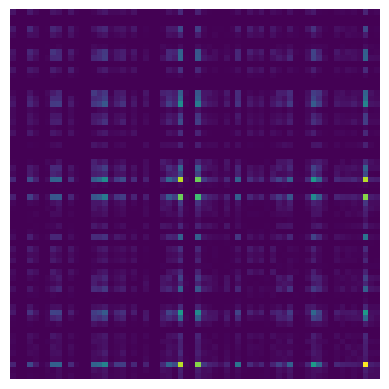

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


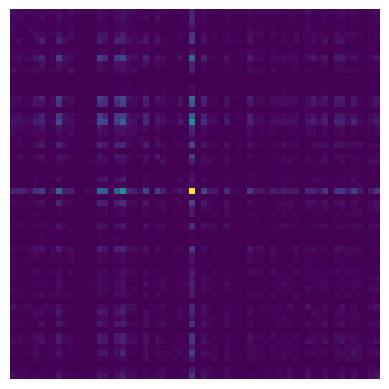

In [8]:
def visualize_gram_matrix(model, image, layer_name):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_output)
    feature_maps = intermediate_model.predict(image)
    gram = gram_matrix(feature_maps)
    
    plt.imshow(gram[0], cmap='viridis')
    plt.axis('off')
    plt.show()

visualize_gram_matrix(vgg, style_image, 'block1_conv1')
visualize_gram_matrix(vgg, combination_image, 'block1_conv1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


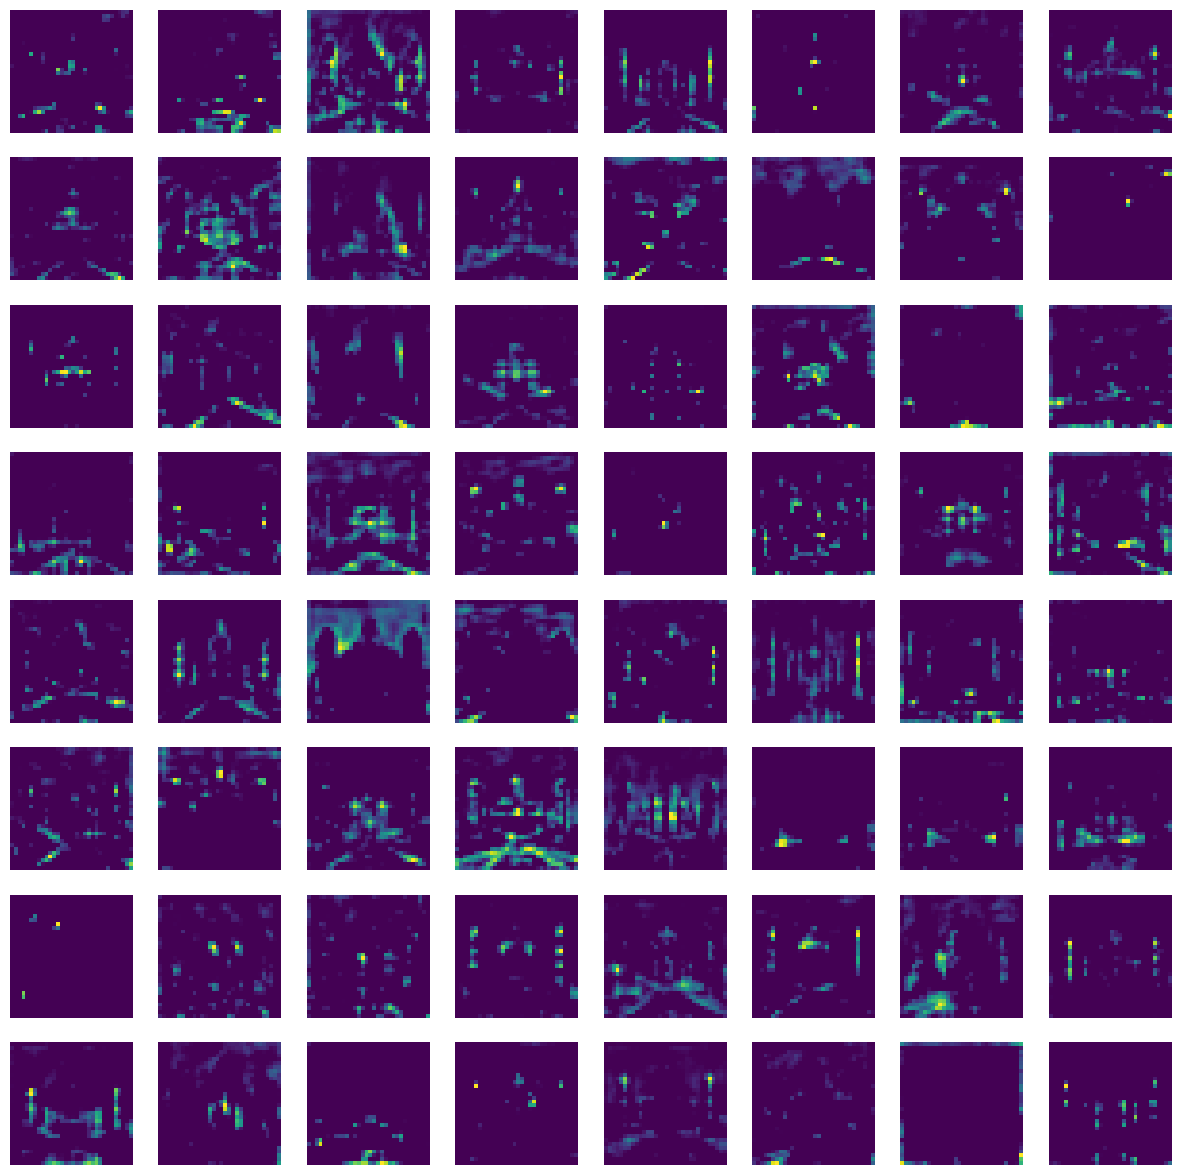

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


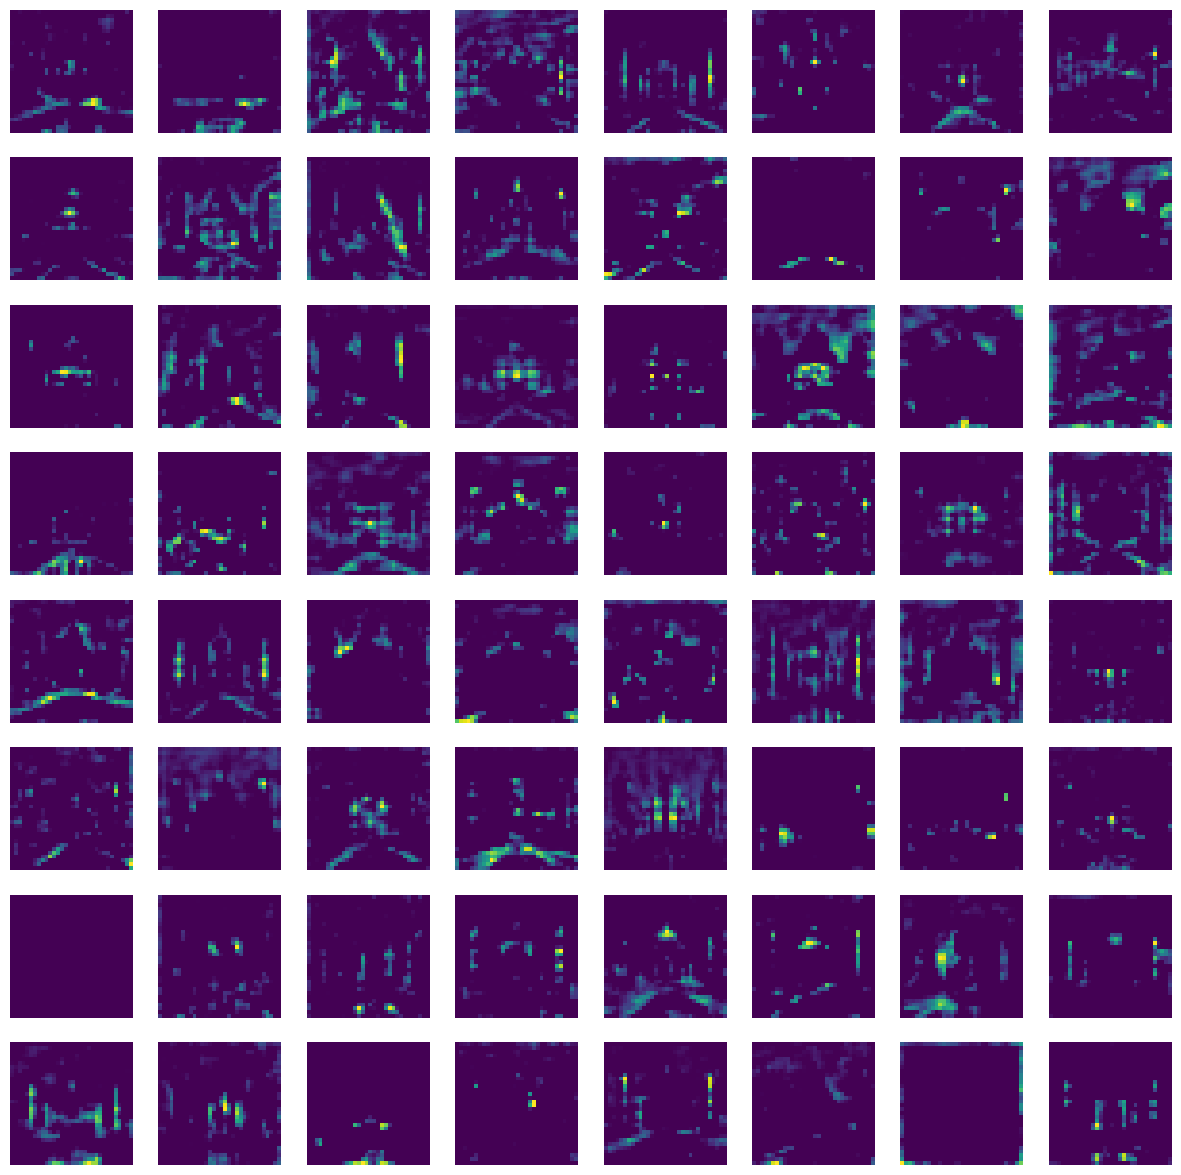

In [9]:
def visualize_feature_maps(model, image, layer_name):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_output)
    feature_maps = intermediate_model.predict(image)
    
    plt.figure(figsize=(15, 15))
    for i in range(min(64, feature_maps.shape[-1])):
        plt.subplot(8, 8, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

visualize_feature_maps(vgg, content_image, 'block5_conv2')
visualize_feature_maps(vgg, combination_image, 'block5_conv2')

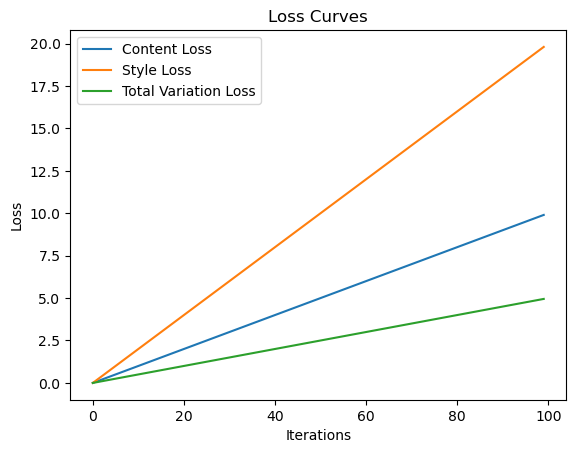

In [12]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
num_iterations = 100
content_losses = [0.1 * i for i in range(num_iterations)]
style_losses = [0.2 * i for i in range(num_iterations)]
tv_losses = [0.05 * i for i in range(num_iterations)]

# Plotting
iterations = range(num_iterations)

plt.plot(iterations, content_losses, label='Content Loss')
plt.plot(iterations, style_losses, label='Style Loss')
plt.plot(iterations, tv_losses, label='Total Variation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()